In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imageio
import importlib_resources
import pathlib

In [14]:
cap = cv2.VideoCapture("data/slow_car.mp4")
ret, frame = cap.read()
frames = []
while 1:

    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)



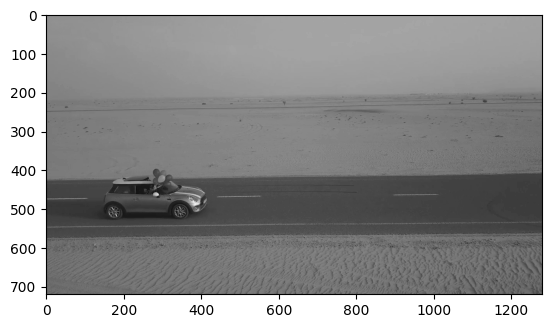

In [3]:
plt.figure()
plt.imshow(frames[101], cmap="gray")

In [4]:
car_data = cv2.CascadeClassifier("./data/cars.xml")

In [20]:
new_frames = []
current_y = 0
current_h = 0
for frame_original in frames:
    frame = frame_original.copy()
    frame_blur = cv2.GaussianBlur(frame, (5, 5), 0)
    frame_dilated = cv2.dilate(frame_blur, np.ones((3, 3)))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    closing = cv2.morphologyEx(frame_dilated, cv2.MORPH_CLOSE, kernel)
    cars = car_data.detectMultiScale(closing, 1.1, 1)
    if len(cars) == 0:
        frame[current_y + current_h :] = 0
        frame[: current_y - current_h - 50] = 0
        new_frames.append(frame)
        continue
    if len(cars) > 1:
        cars = cars[:1]
    for x, y, w, h in cars:
        frame[y + h :] = 0
        frame[:y - h -50] = 0
        current_y = y
        current_h = h
        # frame[:, x + w + 500 :] = 0
        # frame[:, : x -100 ] = 0

    new_frames.append(frame)


# frame = frames[101].copy()
# frame_blur = cv2.GaussianBlur(frame, (5, 5), 0)
# frame_dilated = cv2.dilate(frame_blur, np.ones((3, 3)))
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
# closing = cv2.morphologyEx(frame_dilated, cv2.MORPH_CLOSE, kernel)
# cars = car_data.detectMultiScale(closing, 1.1, 1)
# cnt = 0
# for x, y, w, h in cars:
#     frame[y + h :] = 0
#     frame[:y - h -50] = 0
#     frame[:, x + w + 500 :] = 0
#     frame[:, : x -100 ] = 0

#     cnt += 1
# print(cnt, " cars found")
# plt.figure()
# plt.imshow(frame, cmap="gray")

23.976023976023978


<Figure size 640x480 with 0 Axes>

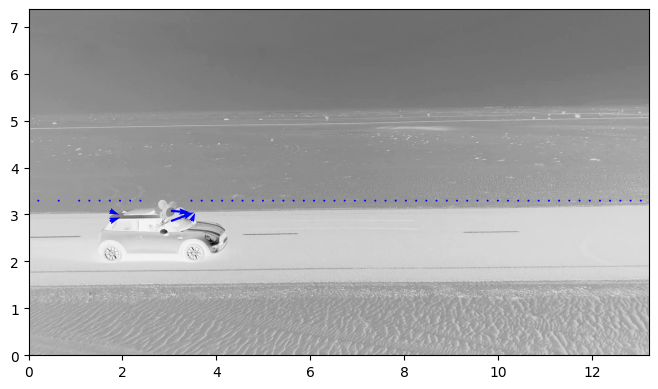

<Figure size 640x480 with 0 Axes>

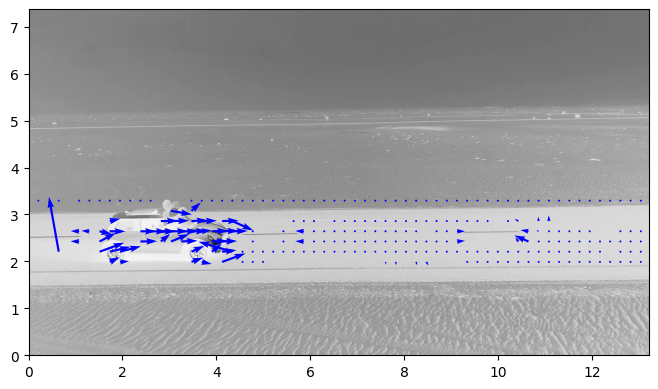

<Figure size 640x480 with 0 Axes>

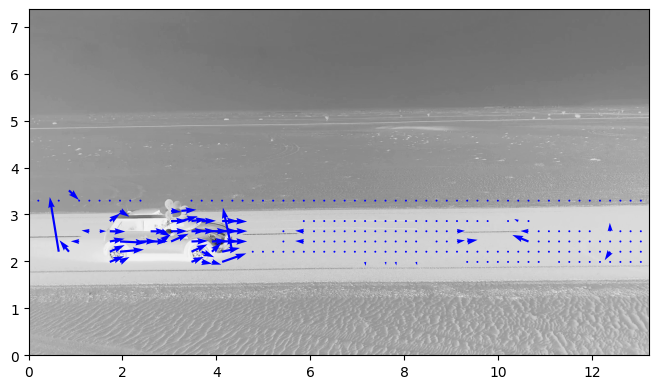

<Figure size 640x480 with 0 Axes>

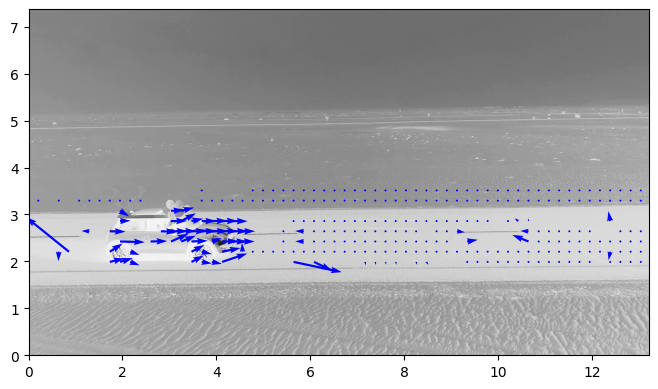

<Figure size 640x480 with 0 Axes>

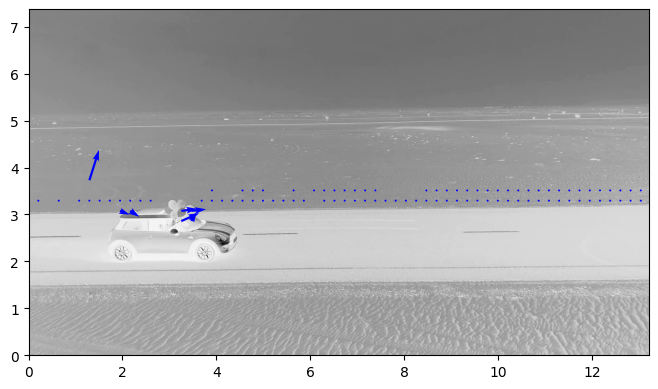

<Figure size 640x480 with 0 Axes>

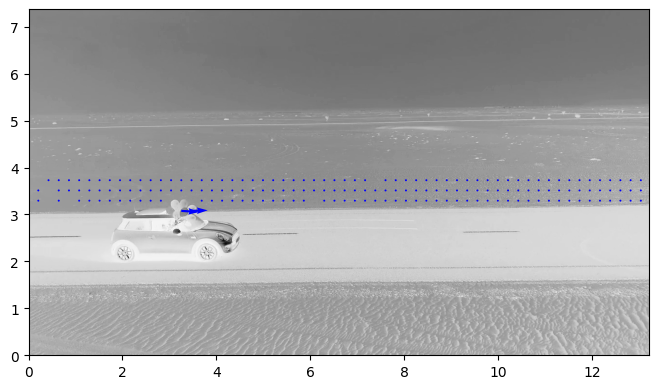

<Figure size 640x480 with 0 Axes>

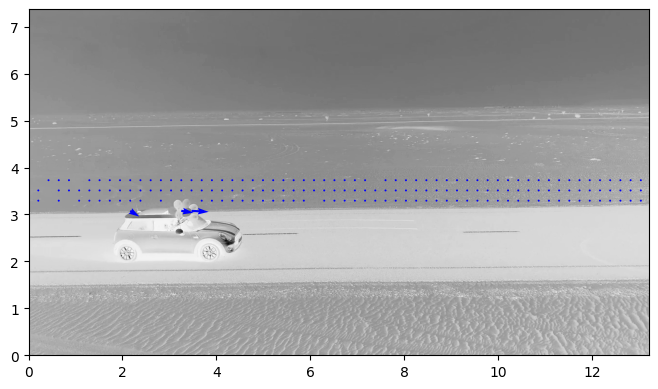

<Figure size 640x480 with 0 Axes>

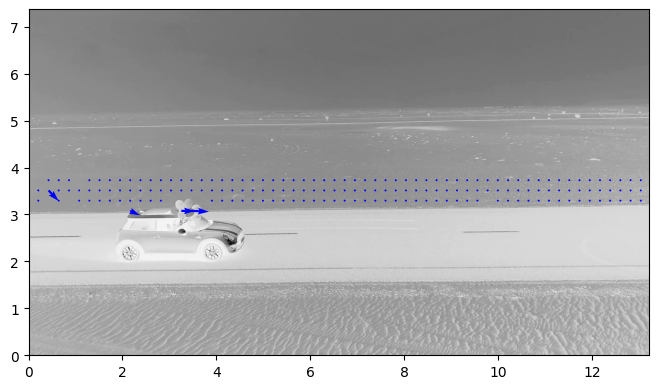

<Figure size 640x480 with 0 Axes>

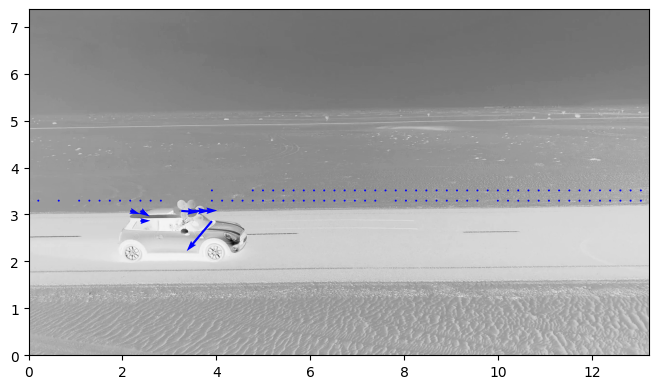

<Figure size 640x480 with 0 Axes>

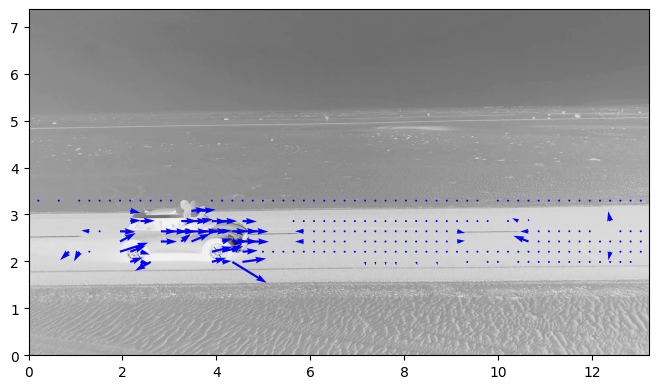

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [26]:

fps = cap.get(cv2.CAP_PROP_FPS)

winsize = 32  # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17  # pixels, 50% overlap
dt = 1/fps  # sec, time interval between the two frames
for i in range(100, len(new_frames) - 1):
    plt.figure()
    cv2.imwrite("frameA.png", frames[i])
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        new_frames[i].astype(np.int32),
        new_frames[i + 1].astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method="peak2peak",
    )

    x, y = pyprocess.get_coordinates(
        image_size=new_frames[50].shape,
        search_area_size=searchsize,
        overlap=overlap,
    )
    invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold=1.05,
    )

    u2, v2 = filters.replace_outliers(
        u0,
        v0,
        invalid_mask,
        method="localmean",
        max_iter=10,
        kernel_size=3,
    )

    # convert x,y to mm
    # convert u,v to mm/sec

    x, y, u3, v3 = scaling.uniform(
        x,
        y,
        u2,
        v2,
        scaling_factor=96.52,  # 96.52 pixels/millimeter
    )

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

    fig, ax = plt.subplots(figsize=(8, 8))
    tools.save("exp1_001.txt", x, y, u3, v3, invalid_mask)
    tools.display_vector_field(
        pathlib.Path("exp1_001.txt"),
        ax=ax,
        scaling_factor=96.52,
        scale=50,  # scale defines here the arrow length
        width=0.0035,  # width is the thickness of the arrow
        on_img=True,  # overlay on the image
        image_name="frameA.png",
        show_invalid=False,
    )
    plt.show()